In [1]:
# Misc imports
import sys
sys.path.append('/storage/vbutoi/projects')
sys.path.append('/storage/vbutoi/libraries')
sys.path.append('/storage/vbutoi/projects/ESE')
sys.path.append('/storage/vbutoi/projects/UniverSeg')
import torch
torch.set_printoptions(linewidth=200)
import seaborn as sns
sns.set_style("darkgrid")
import os 
os.environ['DATAPATH'] = ':'.join((
       '/storage/vbutoi/datasets',
))
import yaml
from pathlib import Path
# Local imports
from ese.scripts.utils import get_option_product
from ese.experiment.analysis.run_inference import get_cal_stats
from ese.experiment.analysis.ensemble_upperbound import get_ensemble_ub
from ese.experiment.analysis.analysis_utils.submit_utils import get_ese_inference_configs
# Ionpy imports
from ionpy.util import Config
from ionpy.analysis import ResultsLoader

# Define some useful paths.
scratch_root = Path("/storage/vbutoi/scratch/ESE")
code_root = Path("/storage/vbutoi/projects/ESE")
rs = ResultsLoader()

# For using code without restarting.
%load_ext autoreload
%autoreload 2
# For using yaml configs.
%load_ext yamlmagic

/local/vbutoi/envs/UniverSegTF/lib/python3.9/site-packages/pydantic/_internal/_fields.py:149: UserWarning: Field "model_outputs" has conflict with protected namespace "model_".

You may be able to resolve this warning by setting `model_config['protected_namespaces'] = ()`.
  warnings.warn(


In [2]:
%%yaml inference_config

log:
    root: '?'
    min_fg_pixels: '?' 
    gether_inference_stats: '?'
    summary_compute_global_metrics: '?' 
    log_interval: 20 
    log_image_stats: True 
    log_pixel_stats: True 
    track_ensemble_member_scores: True 

experiment:
    exp_root: '?'
    seed: 42

data:
    splits: ('val', 'cal')
    preload: False 

dataloader:
    batch_size: 1 
    num_workers: 0
    pin_memory: True 

model:
    calibrator: '?'
    checkpoint: '?' 
    pretrained_exp_root : None
    pretrained_select_metric: "val-dice_score"

<IPython.core.display.Javascript object>

In [3]:
%%yaml ensemble_cfg

ensemble:
    combine_fn: '?'
    combine_quantity: '?'
    member_w_metric: None
    member_paths: None
    normalize: False

<IPython.core.display.Javascript object>

In [4]:
######################################3
exp_name = '03_20_24_RandomCircles_Dice_VES'
group_dict = {
    "dataset": "Shapes",
    "exp_group": exp_name,
    "base_models_group": "03_13_24_RandomCircles_BigEnsemble",
    "calibrated_models_group": "03_20_24_RandomCircles_BigEnsemble_Dice_Calibrated"
}

In [5]:
%%yaml base_cfg_args

exp_opts:
    log.gether_inference_stats: [True]
    log.summary_compute_global_metrics: [True]
    data.subsplit: [0]

submit_opts:
    max_ensemble_samples: 5
    num_ens_membs:
        - 2
        # - 4
        # - 8
        # - 12
        # - 16


<IPython.core.display.Javascript object>

In [6]:
%%yaml inference_config_opts

calibrator:
    - Uncalibrated
    # - TempScaling
    # - LTS

do_ensemble:
    - True
    # - False

model_pair_temps:
    - (1.0, 1.0)
    - (0.1, 1.9)
    - (1.9, 0.1)
    - (0.1, 0.1)
    - (1.9, 1.9)

<IPython.core.display.Javascript object>

### Standard Calibrators.

In [7]:
inference_func = get_cal_stats
# Get the configs for the different runs.
option_set = get_ese_inference_configs(
    group_dict=group_dict,
    inf_cfg_opts=inference_config_opts,
    base_cfg_args=base_cfg_args
)

In [8]:
len(option_set)

25

### Binning Calibrators

In [10]:
# do_ensemble = True 
# inference_func = get_cal_stats
# # Get the configs for the different runs.
# option_set = get_ese_inference_configs(
#     group_dict=group_dict,
#     calibrators_list=[
#         'HistogramBinning',
#         'LocalHistogramBinning',
#         'NectarBinning',
#         'SoftNectarBinning'
#     ], 
#     do_ensemble=do_ensemble, 
#     cal_stats_splits=[
#         'val',
#         'cal'
#     ],
#     additional_args=additional_args
# )

### Upper Bounds

In [11]:
# # # Get the configs for computing the upepr bounds
# inference_func = get_ensemble_ub
# option_set = get_ese_inference_configs(
#     group_dict=group_dict,
#     do_ensemble=True, 
#     ensemble_upper_bound=True,
#     calibrators_list=[
#         'Uncalibrated',
#     ], 
#     ens_cfg_options=[
#         ('upperbound', 'probs')
#     ]
# )

In [12]:
# Load the inference cfg from local.
##################################################
inf_cfg_root = code_root / "ese" / "experiment" / "configs" / "inference"

##################################################
with open(inf_cfg_root / f"{group_dict['dataset']}.yaml", 'r') as file:
    dataset_inference_cfg = yaml.safe_load(file)
with open(inf_cfg_root / "Calibration_Metrics.yaml", 'r') as file:
    cal_metrics_cfg = yaml.safe_load(file)

##################################################
base_cfg = Config(inference_config).update([dataset_inference_cfg, cal_metrics_cfg, ensemble_cfg])
# Get the configs
cfgs = get_option_product(exp_name, option_set, base_cfg)

## Running Jobs

In [13]:
from ese.experiment.analysis.run_inference import get_cal_stats

Set seed: 42


/storage/vbutoi/projects/ionpy/util/libcheck.py:49: UserWarning: Intel MKL extensions not available for NumPy
  warn("Intel MKL extensions not available for NumPy")
/storage/vbutoi/projects/ionpy/util/libcheck.py:57: UserWarning: Using slow Pillow instead of Pillow-SIMD
  warn("Using slow Pillow instead of Pillow-SIMD")


Set seed: 48
Set seed: 45
Set seed: 42
Running:

data:
  preload: false
  splits: ('val', 'cal')
  subsplit: 0
dataloader:
  batch_size: 1
  num_workers: 0
  pin_memory: true
dataset:
  _class: ese.experiment.datasets.Shapes
  augmentations: null
  binarize: true
  preload: false
  return_data_id: true
  subsplit: 0
  version: 3.0
ensemble:
  combine_fn: mean
  combine_quantity: probs
  member_paths:
  - /storage/vbutoi/scratch/ESE/training/03_13_24_RandomCircles_BigEnsemble/20240313_221119-QUDQ-2600760c1d77f08bac9748b611c90023
  - /storage/vbutoi/scratch/ESE/training/03_13_24_RandomCircles_BigEnsemble/20240313_221110-R3YY-d01a7d4f59d80a600b71ab9636700e05
  member_w_metric: None
  normalize: false
experiment:
  dataset_name: Shapes
  exp_root: /storage/vbutoi/scratch/ESE/inference/03_20_24_RandomCircles_Dice_VES
  pretrained_seed: 42
  seed: 42
global_cal_metrics:
- ECE:
    _fn: ese.experiment.metrics.ece.ece_loss
    cal_type: toplabel
- Edge-ECE:
    _fn: ese.experiment.metrics.ece.

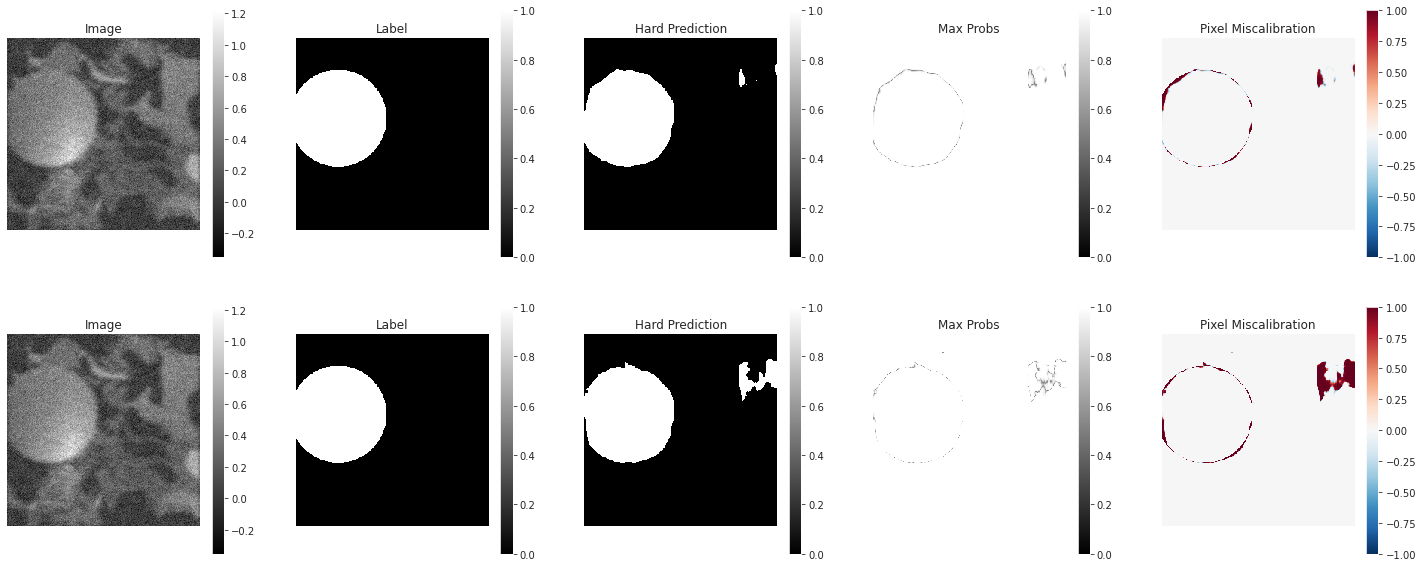

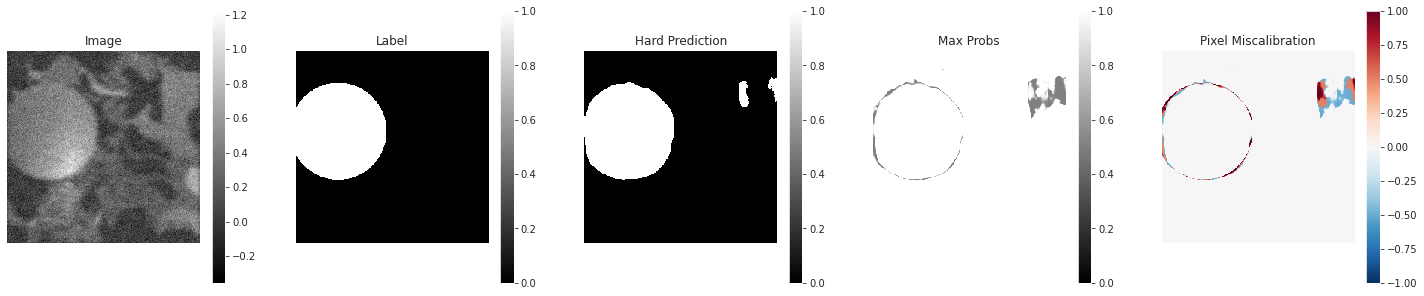

Dice: 0.9594156742095947
HD95: 138.85855102539062
BoundaryIOU: 0.16180600225925446
Accuracy: 0.984130859375
Recall: 0.9740641117095947
Precision: 0.9451285004615784
Pixel-Ambiguity: 0.005466046743094921
Soft-Region-Ambiguity: 0.008691519498825073
Hard-Region-Ambiguity: 0.01984536647796631
Image_ECE: 0.006725294442730956
Image_Edge-ECE: 0.20387731599697106
Image_CW-ECE: 0.011582977138459682
Image_ECW-ECE: 0.01810615323483944
Image_Uniform-CW-ECE: 0.011582977138459682
Image_Uniform-ECW-ECE: 0.020917074754834175
Image_ELM: 0.007989083416759968
Image_Edge-ELM: 0.21718546748161316
Image_Uniform-ELM: 0.2322015017271042
Image_Uniform-Edge-ELM: 0.21471895277500153


KeyboardInterrupt: 

In [14]:
from ese.experiment.experiment import run_ese_exp

###### Run individual jobs
run_ese_exp(
    config=cfgs[0], 
    job_func=get_cal_stats,
    run_name='debug',
    show_examples=True,
    gpu='3',
) 

In [ ]:
# from ese.experiment.experiment import submit_ese_exps 

# #### Run Batch Jobs
# submit_ese_exps(
#     config_list=cfgs,
#     job_func=get_cal_stats,
#     # available_gpus=['0', '1', '2', '3'],
#     available_gpus=['2', '3', '4', '5', '6', '7'],
# )